# Base Network

In [2]:
import os, random
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

def get_dataloaders(batch_size=16, val_frac=0.1):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    val_size = int(len(trainset_full) * val_frac)
    train_size = len(trainset_full) - val_size
    trainset, valset = random_split(trainset_full, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return trainloader, valloader, testloader

def accuracy(outputs, targets):
    preds = outputs.argmax(dim=1)
    return (preds == targets).float().mean().item()

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        bs = labels.size(0)
        running_loss += loss.item() * bs
        running_acc += accuracy(outputs, labels) * bs
        n += bs
    return running_loss / n, running_acc / n

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        bs = labels.size(0)
        running_loss += loss.item() * bs
        running_acc += accuracy(outputs, labels) * bs
        n += bs
    return running_loss / n, running_acc / n

In [ ]:
set_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

trainloader, valloader, testloader = get_dataloaders(batch_size=16, val_frac=0.1)

model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

best_val_acc = 0.0
best_path = 'best_cifar10_baseline.pt'

epochs = 20
for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, valloader, criterion, device)
    print(f'Epoch {epoch:02d} | train_loss={tr_loss:.4f} | train_acc={tr_acc:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state': model.state_dict()}, best_path)

ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
te_loss, te_acc = evaluate(model, testloader, criterion, device)
print(f'Test: loss={te_loss:.4f} | acc={te_acc:.4f} ({te_acc*100:.2f}%)')

Epoch 01 | train_loss=2.0337 | train_acc=0.2483 | val_loss=1.7392 | val_acc=0.3590
Epoch 02 | train_loss=1.5581 | train_acc=0.4286 | val_loss=1.5053 | val_acc=0.4570
Epoch 03 | train_loss=1.4019 | train_acc=0.4920 | val_loss=1.3418 | val_acc=0.5138
Epoch 04 | train_loss=1.2919 | train_acc=0.5360 | val_loss=1.2673 | val_acc=0.5454
Epoch 05 | train_loss=1.2089 | train_acc=0.5683 | val_loss=1.2597 | val_acc=0.5474
Epoch 06 | train_loss=1.1408 | train_acc=0.5914 | val_loss=1.1381 | val_acc=0.5974
Epoch 07 | train_loss=1.0858 | train_acc=0.6169 | val_loss=1.1249 | val_acc=0.6014
Epoch 08 | train_loss=1.0324 | train_acc=0.6344 | val_loss=1.0874 | val_acc=0.6076
Epoch 09 | train_loss=0.9910 | train_acc=0.6497 | val_loss=1.0575 | val_acc=0.6312
Epoch 10 | train_loss=0.9484 | train_acc=0.6639 | val_loss=1.0469 | val_acc=0.6314
Epoch 11 | train_loss=0.9102 | train_acc=0.6776 | val_loss=1.0304 | val_acc=0.6394
Epoch 12 | train_loss=0.8719 | train_acc=0.6935 | val_loss=1.0685 | val_acc=0.6246
Epoc

# Dendritic Network

In [2]:
!git clone https://github.com/PerforatedAI/PerforatedAI.git
!cd PerforatedAI/ && pip install -e .

Cloning into 'PerforatedAI'...
remote: Enumerating objects: 1684, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 1684 (delta 119), reused 117 (delta 115), pack-reused 1507 (from 3)
Receiving objects: 100% (1684/1684), 285.70 MiB | 16.83 MiB/s, done.
Resolving deltas: 100% (984/984), done.
Obtaining file:///content/PerforatedAI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for perforatedai


In [1]:
from perforatedai import globals_perforatedai as GPA
from perforatedai import utils_perforatedai as UPA

GPA.pc.set_testing_dendrite_capacity(False)

Building dendrites without Perforated Backpropagation


In [3]:
set_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

trainloader, valloader, testloader = get_dataloaders(batch_size=16, val_frac=0.1)

model = Net()
model = UPA.initialize_pai(model)
model.to(device)

criterion = nn.CrossEntropyLoss()

GPA.pai_tracker.set_optimizer(optim.SGD)
optimArgs = {'params':model.parameters(), 'lr': 1e-3, 'momentum': 0.9}
optimizer = GPA.pai_tracker.setup_optimizer(model, optimArgs)

best_val_acc, best_path = 0.0, 'best_cifar10_pai.pt'
epoch = 0

while True:
    epoch += 1
    tr_loss, tr_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, valloader, criterion, device)

    print(f'Epoch {epoch:02d} | train_loss={tr_loss:.4f} | train_acc={tr_acc:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f}')

    GPA.pai_tracker.add_extra_score(tr_acc, 'Train Accuracy')
    GPA.pai_tracker.add_extra_score(tr_loss, 'Train Loss')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state': model.state_dict()}, best_path)

    model, restructured, training_complete = GPA.pai_tracker.add_validation_score(val_acc, model)
    model.to(device)
    if training_complete:
        print('PAI signaled training is complete.')
        break
    elif restructured:
        optimArgs = {'params':model.parameters(), 'lr': 1e-3, 'momentum': 0.9}
        optimizer = GPA.pai_tracker.setup_optimizer(model, optimArgs)

te_loss, te_acc = evaluate(model, testloader, criterion, device)
print(f'Test: loss={te_loss:.4f} | acc={te_acc:.4f} ({te_acc*100:.2f}%)')
GPA.pai_tracker.add_test_score(te_acc, 'Test Accuracy')
GPA.pai_tracker.add_test_score(te_loss, 'Test Loss')

100%|██████████| 170M/170M [00:24<00:00, 6.94MB/s]


Running Dendrite Experiment
Epoch 01 | train_loss=2.0337 | train_acc=0.2483 | val_loss=1.7392 | val_acc=0.3590
Adding validation score 0.35900000
Checking PAI switch with mode n, switch mode DOING_HISTORY, epoch 0, last improved epoch 0, total epochs 0, n: 10, num_cycles: 0
Returning False - no triggers to switch have been hit
Epoch 02 | train_loss=1.5581 | train_acc=0.4286 | val_loss=1.5053 | val_acc=0.4570
Adding validation score 0.45700000
Checking PAI switch with mode n, switch mode DOING_HISTORY, epoch 1, last improved epoch 1, total epochs 1, n: 10, num_cycles: 0
Returning False - no triggers to switch have been hit
Epoch 03 | train_loss=1.4019 | train_acc=0.4920 | val_loss=1.3418 | val_acc=0.5138
Adding validation score 0.51380000
Checking PAI switch with mode n, switch mode DOING_HISTORY, epoch 2, last improved epoch 2, total epochs 2, n: 10, num_cycles: 0
Returning False - no triggers to switch have been hit
Epoch 04 | train_loss=1.2919 | train_acc=0.5360 | val_loss=1.2673 | v

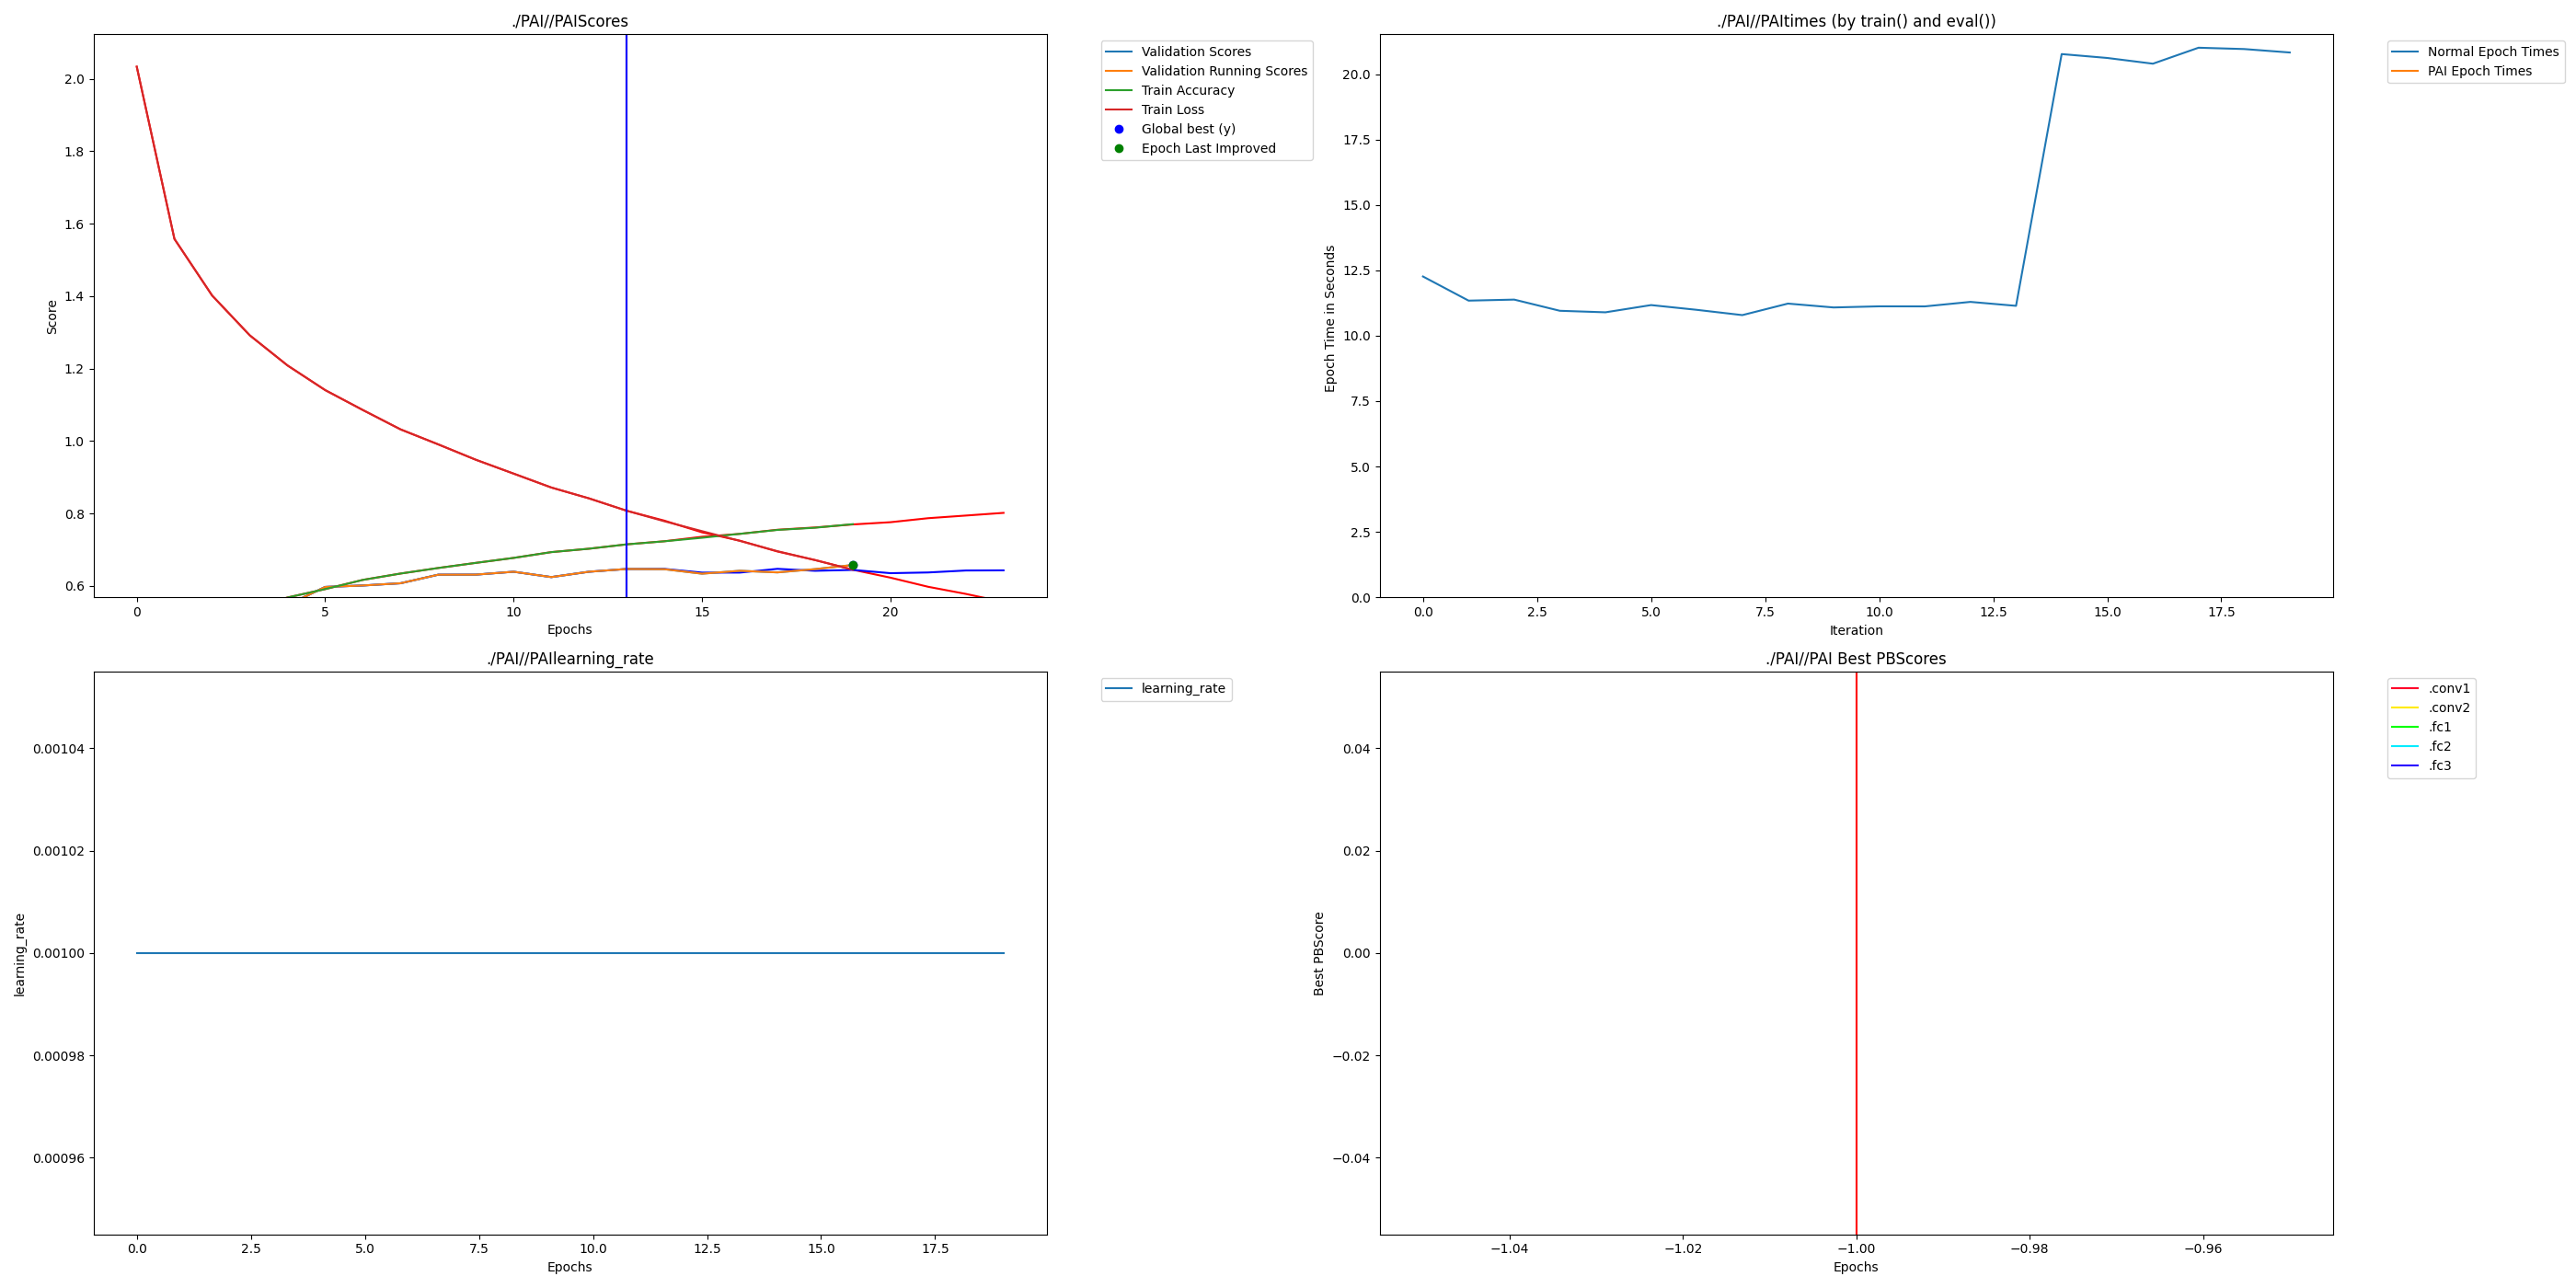

In [5]:
from PIL import Image
from IPython.display import display

img = Image.open('/content/PAI/PAI.png')
display(img)